# kNN

## Creating data

In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
n = 30000

In [ ]:
data = torch.cat([
    torch.rand((n // 3 * 2, 2)) * 1.5,
    torch.randn((n // 3, 2)) * 2 + torch.tensor([6, 5])
])

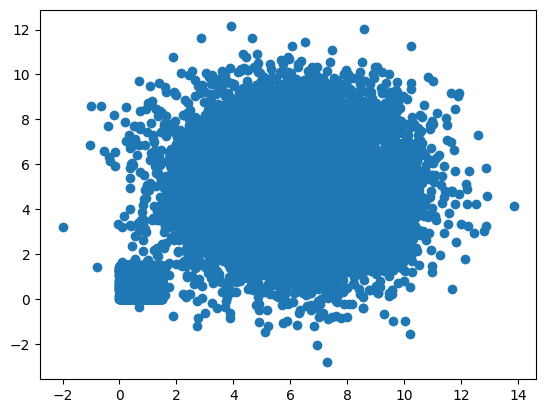

In [ ]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

## Nearest Neighbors


In [ ]:
k = 7
point = torch.tensor([2, 2])

We don't need the exact distances, so we will just use squared distances and call them dist anyway.

In [ ]:
dist = ((data - point) ** 2).sum(1)
dist.shape

torch.Size([30000])

In [ ]:
closest_k = torch.topk(dist, k, largest=False)
closest_k.indices[:3], closest_k.values.shape, closest_k.indices.shape

(tensor([28886, 21244, 21312]), torch.Size([7]), torch.Size([7]))

In [ ]:
def show_closest(data, closest, p):
    plt.scatter(data[:, 0], data[:, 1])
    closest = data[closest]
    plt.scatter(closest[:, 0], closest[:, 1], c="orange")
    plt.scatter(p[0], p[1], c="black")
    plt.show()

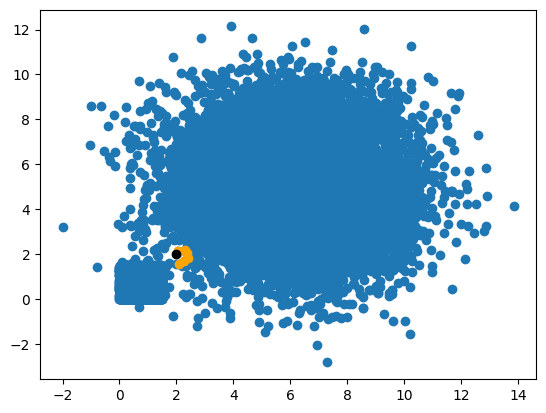

In [ ]:
show_closest(data, closest_k.indices, point)

In [ ]:
def knn(data, p, k):
    dist = ((data - p) ** 2).sum(1)
    return torch.topk(dist, k, largest=False)

In [ ]:
%timeit -n 10 _=knn(data, point, k)

282 µs ± 63 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
data_c = data.cuda()
point_c = point.cuda()

In [ ]:
%timeit -n 10 _=knn(data_c, point_c, k).indices.cpu()

The slowest run took 28.95 times longer than the fastest. This could mean that an intermediate result is being cached.
1.33 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 _=knn(data_c, point_c, k).indices

147 µs ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Batched

In [ ]:
points = torch.tensor([
    [0, 0],
    [2, 2],
    [10, 0]
])

In [ ]:
dist = (((data[None] - points[:, None]) ** 2).sum(2)).sqrt()
dist.shape

torch.Size([3, 30000])

In [ ]:
closests = torch.topk(dist, k, largest=False).indices

In [ ]:
def show_closest(data, closest, ps):
    plt.scatter(data[:, 0], data[:, 1])
    closest = data[closest.reshape(-1)]
    plt.scatter(closest[:, 0], closest[:, 1], c="orange")
    plt.scatter(ps[:, 0], ps[:, 1], c="black")
    plt.show()

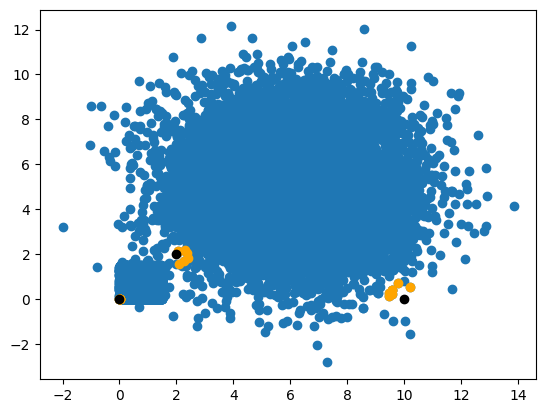

In [ ]:
show_closest(data, closests, points)

In [ ]:
def knn(data, ps, k):
    dist = (((data[None] - ps[:, None]) ** 2).sum(2)).sqrt()
    return torch.topk(dist, k, largest=False)

In [ ]:
points = torch.randn((1000, 2))

In [ ]:
%timeit -n 5 _=knn(data, points, k)

180 ms ± 6.81 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [ ]:
points_c = points.cuda()

In [ ]:
%timeit -n 5 _=knn(data_c, points_c, k).indices.cpu()

72.3 ms ± 7.81 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [ ]:
%timeit -n 5 _=knn(data_c, points_c, k)

228 µs ± 153 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Approximate - CPU with quadtree

In [ ]:
torch.zeros((30,40)).min(dim=0).values.shape

torch.Size([40])

In [ ]:
class Node:
    splits = None
    children = None
    values = None

    def __init__(
        self,
        max_leaf,
        values  # (n, d)
    ):
        if len(values) > max_leaf:
            self.split(values)
        else:
            self.values = values

    def split(self, values):
        mins = values.min(dim=0).values
        maxs = values.max(dim=0).values
        self.splits = mins + (maxs - mins) / 2
        mask = values < self.splits
        # self.children = np.empty()
        d = values.shape[1]
        one_over_max_idx = 2 ** d
        print(one_over_max_idx)
        mask *= np.array([2 ** i for i in range(d)])
        mask = mask.sum(dim=1)
        print(mask.shape)
        print(mask)

In [ ]:
import numpy as np

In [ ]:
np.empty((2,2,2,2))[np.ones((20, 4), dtype=bool).T].shape

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 4

In [ ]:
np.array([Node(21, torch.randn(20, 3))])

array([<__main__.Node object>], dtype=object)

In [ ]:
Node(4, torch.randn(20, 3))

8
torch.Size([20])
tensor([1, 1, 3, 5, 2, 3, 5, 0, 3, 5, 7, 5, 3, 7, 0, 4, 2, 5, 3, 0])


<__main__.Node>